In [1]:
!pip install eagleSqlTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

con = sql.connect("vwg533", password = "FZtn087h")

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.

Query_IDs = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            SH.GalaxyID as id \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Data_IDs = sql.execute_query(con, Query_IDs)

In [ ]:
for i in range(len(Data_IDs['id'])):
  print('ID:' ,Data_IDs['id'][i])
  print('u-r:' ,Data_IDs['u_minus_r'][i])
  print('Mass:' ,Data_IDs['mass'][i])
  print('sSFR:' ,Data_IDs['ssfr'][i])
  print('')

Streaming output truncated to the last 5000 lines.
ID: 9805592
u-r: 1.4886036
Mass: 10.277714164937553
sSFR: 5.6523026e-11

ID: 9897265
u-r: 1.659689
Mass: 10.308562383918048
sSFR: 3.213921e-11

ID: 9909258
u-r: 1.175396
Mass: 10.30474360771978
sSFR: 1.3896283e-10

ID: 9934326
u-r: 1.7402115
Mass: 10.497834703069003
sSFR: 2.7529043e-11

ID: 9964678
u-r: 1.4901905
Mass: 9.966200040910893
sSFR: 5.4236907e-11

ID: 10005161
u-r: 1.3105946
Mass: 10.232009466498509
sSFR: 8.884996e-11

ID: 10035406
u-r: 1.0904121
Mass: 9.866292640871599
sSFR: 1.9150852e-10

ID: 10042583
u-r: 2.204874
Mass: 10.054877735733363
sSFR: 6.658251e-12

ID: 10080501
u-r: 1.6042213
Mass: 10.224979059317514
sSFR: 4.241344e-11

ID: 9383525
u-r: 2.337738
Mass: 10.3893952939169
sSFR: 3.5252226e-12

ID: 9621245
u-r: 1.8207226
Mass: 10.507162353016717
sSFR: 2.4168325e-11

ID: 9709796
u-r: 1.4601746
Mass: 10.183454832296233
sSFR: 6.494262e-11

ID: 8926834
u-r: 0.99136734
Mass: 10.055371676219835
sSFR: 2.5858057e-10

ID: 92620

In [9]:
sim_name = 'RefL0100N1504'
sim_size = 100.
galaxy_id_1 = 18104017
galaxy_id_2 = 9237862

# Red
Query_1 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_1)

# Blue
Query_2 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_2)

Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
r = len(Data_1['z'])
b = len(Data_2['z'])

In [4]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [5]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

In [37]:
sSFR_1 = divide_with_zeros(Data_1['sfr'], Data_1['mass']) * 10**9

r_snapnums = np.arange(29-len(Data_1['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_1['mass'])
r_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, r_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  r_medians = r_medians + [np.median(Galaxies['ssfr'])]
  #print(Galaxies['mass'])
r_medians = np.array(r_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum possible snapnum /Gyr^-1
print(r_medians)
print(len(sSFR_1) - len(r_medians))

[ 0.03049488  0.04486999  0.05189739  0.06688403  0.07850626  0.08665954
  0.11037526  0.13676089  0.21344726  0.27798358  0.50811938  0.6763205
  0.81613249  0.9792096   1.13251941  1.30330047  1.69120473  2.15235563
  2.3963016   2.46092546  2.82356449  2.67307509  3.48059404  2.4534863
  2.32693642  3.31466121  1.85918703 20.81451989]
0


In [38]:
sSFR_2 = divide_with_zeros(Data_2['sfr'], Data_2['mass']) * 10**9

b_snapnums = np.arange(29-len(Data_2['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_2['mass'])
b_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, b_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  b_medians = b_medians + [np.median(Galaxies['ssfr'])]
  #print(Galaxies['mass'])
b_medians = np.array(b_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(b_medians)
print(len(sSFR_2) - len(b_medians))

[0.04458611 0.05868185 0.0694199  0.08632381 0.1069102  0.14790937
 0.23878741 0.2931895  0.35504288 0.42355378 0.52243432 0.63719141
 0.75072354 0.8955201  0.98328568 1.11578613 1.35066025 1.48678425
 1.65130343 0.51222038 1.63867908 0.77575818 0.22577483 0.25999766
 0.74003847 1.94396188 2.09380513]
0


In [39]:
r_diffs = log_with_zeros(sSFR_1) - log_with_zeros(r_medians)
print(r_diffs)

b_diffs = log_with_zeros(sSFR_2) - log_with_zeros(b_medians)
print(b_diffs)

[-6.19287533e-01 -8.64129610e-01 -1.42269745e+00 -9.42912817e-01
 -1.72535914e+00 -8.28209380e-01 -1.20484246e+00 -6.40099210e-01
  6.66563319e-01  4.15632586e-01  2.52046382e-01  7.41156964e-02
 -1.28582381e-01 -1.39683563e-02  2.75310072e-01  1.30118224e-01
 -3.62166901e-03 -1.31892878e-01  6.45889555e-02 -1.46470331e-01
 -3.39899864e-01 -8.12566616e-02 -4.53350470e-01  4.45526675e-01
  2.03036324e-01  5.64933012e-01  3.92299045e-01 -4.14882123e+00]
[ 0.19456533  0.0487776  -0.1082525  -0.24445186  0.26962465  0.3042164
  0.19624905  0.4064484   0.09685862  0.04932349  0.13578233  0.01359182
  0.10509659 -0.30813449  0.20757705 -0.41526089 -0.16933603 -0.37718735
  0.08854546 -0.03957501 -0.76126906  1.19191373  0.78749175  0.95935964
 -1.17757556 -1.59700901 -1.62925752]


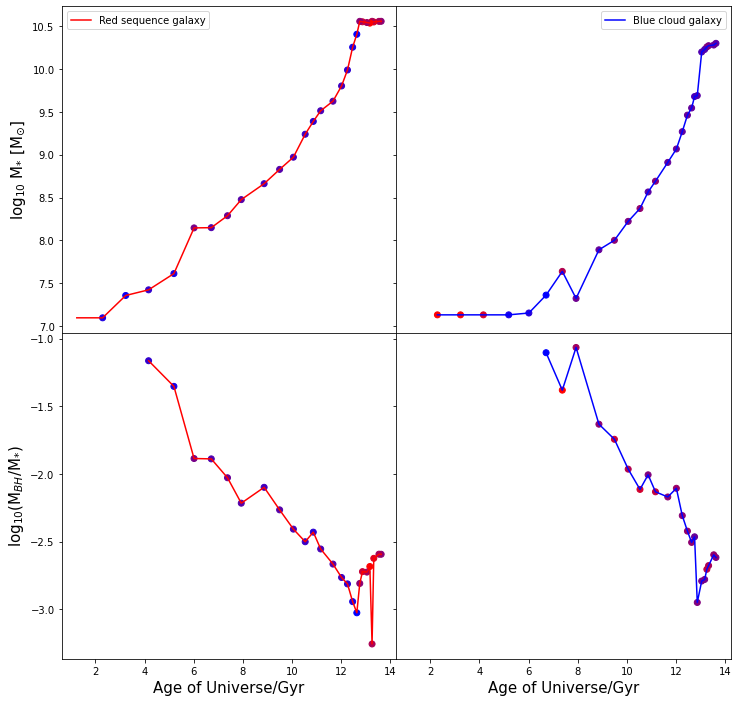

In [46]:
cvals = [-1, 0, 1]
colors = ["red","purple","blue"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

ratio_red = remove_zeros(divide_with_zeros(Data_1['bh'], Data_1['mass']))
ratio_blue = remove_zeros(divide_with_zeros(Data_2['bh'], Data_2['mass']))
r2 = len(ratio_red)
b2 = len(ratio_blue)

fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (12,12), sharex = True, sharey = 'row')
ax1[0].plot(Times[0:r], log_with_zeros(Data_1['mass']), color = 'r', label = 'Red sequence galaxy')
ax1[1].plot(Times[0:b], log_with_zeros(Data_2['mass']), color = 'b', label = 'Blue cloud galaxy')
ax2[0].plot(Times[0:r2], log_with_zeros(ratio_red), color = 'r', label = 'Red sequence galaxy')
ax2[1].plot(Times[0:b2], log_with_zeros(ratio_blue), color = 'b', label = 'Blue cloud galaxy')

ax1[0].scatter(Times[0:r-1], log_with_zeros(Data_1['mass'])[0:-1], c = r_diffs[0:-1], cmap = cmap)
ax1[1].scatter(Times[0:b], log_with_zeros(Data_2['mass']), c = b_diffs, cmap = cmap)
ax2[0].scatter(Times[0:r2], log_with_zeros(ratio_red), c = r_diffs[0:r2], cmap = cmap)
ax2[1].scatter(Times[0:b2], log_with_zeros(ratio_blue), c = b_diffs[0:b2], cmap = cmap)

ax1[0].set_ylabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=15)
ax2[0].set_xlabel(r'Age of Universe/Gyr', fontsize=15)
ax2[1].set_xlabel(r'Age of Universe/Gyr', fontsize=15)
ax2[0].set_ylabel(r'log$_{10}$(M$_{BH}$/M$_{*}$)', fontsize=15)
plt.subplots_adjust(hspace=.0, wspace=.0)
ax1[0].legend()
ax1[1].legend()
plt.savefig('Plot_2.jpeg')
plt.show()